## MNIST with DDIM

Generate new samples and denoise it to the first time step using the algorithm proposed in [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502) by Song, Jiaming and Meng, Chenlin and Ermon, Stefano (2020).

In [ ]:
using MLDatasets
using Plots
using Images
using BSON
using Flux
using Random
using Printf
using ProgressMeter

In [ ]:
using Revise
using DenoisingDiffusion 
using DenoisingDiffusion: train!, split_validation

## Load

In [ ]:
data_directory="path\\to\\MNIST"
trainset = MNIST(Float32, :train, dir=data_directory)

display(trainset)

dataset MNIST:
  metadata    =>    Dict{String, Any} with 3 entries
  split       =>    :train
  features    =>    28×28×60000 Array{Float32, 3}
  targets     =>    60000-element Vector{Int64}

## Test

### load model

In [ ]:
directory = "../outputs/MNIST_20221016_2007"
diffusion_path = joinpath(directory, "diffusion_epoch=15.bson");
history_path = joinpath(directory, "history.json");

In [ ]:
diffusion = BSON.load(diffusion_path)[:diffusion]
println("data shape:    $(diffusion.data_shape)")
num_timesteps = diffusion.num_timesteps
println("num timesteps: $(num_timesteps)")
diffusion.denoise_fn

data shape:    (28, 28, 1)
num timesteps: 100


UNet(
  embed_layers = Chain(
    SinusoidalPositionEmbedding(100 => 64),
    Dense(64 => 64, gelu),              # 4_160 parameters
    Dense(64 => 64),                    # 4_160 parameters
  ),
  chain = ConditionalChain(
    init = Conv((3, 3), 1 => 16, pad=1),  # 160 parameters
    down_1 = ResBlock(
      in_layers = ConvEmbed(
        embed_layers = Chain(
          NNlib.swish,
          Dense(64 => 16),              # 1_040 parameters
        ),
        conv = Conv((3, 3), 16 => 16, pad=1),  # 2_320 parameters
        norm = GroupNorm(16, 8),        # 32 parameters
        activation = NNlib.swish,
      ),
      out_layers = Chain(
        Conv((3, 3), 16 => 16, pad=1),  # 2_320 parameters
        GroupNorm(16, 8),               # 32 parameters
        NNlib.swish,
      ),
      skip_transform = identity,
    ),
    skip_1 = ConditionalSkipConnection(
      ConditionalChain(
        downsample_1 = Conv((4, 4), 16 => 16, pad=1, stride=2),  # 4_112 parameters
        down_2 = 

### sample

\begin{align} 
x_{t-1} &= \sqrt{\bar{\alpha}_{t-1}} \hat{x}_0 
        + \sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \epsilon_\theta + \sigma_t \epsilon_t \\
 \sigma_t &= \eta \sqrt{\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}} \sqrt{1-\frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}} \\
\hat{x}_0 &= \frac{1}{\sqrt{\bar{\alpha}_t}} x_t - \sqrt{\frac{1}{\bar{\alpha}_t}-1} \epsilon_\theta 
\end{align}

In [ ]:
X0s = ddim_sample_loop(diffusion, 20, 16; to_device=cpu, η=1.0f0) ;
size(X0s)

DDIM Sampling... 100%|███████████████████████████████████| Time: 0:00:17


(28, 28, 1, 16)

In [ ]:
imgs = convert2image(trainset, X0s[:, :, 1, :, end]);

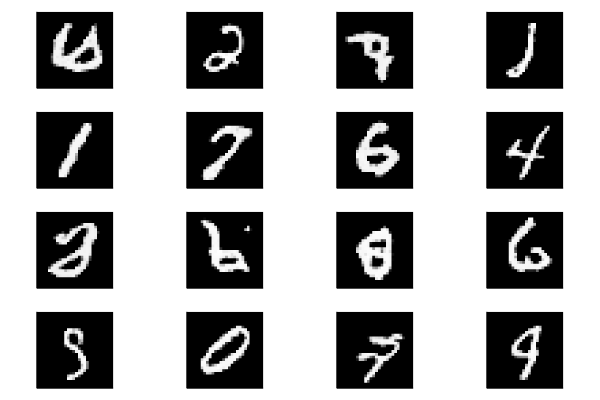

In [ ]:
p = plot([plot(imgs[:, :, i]) for i in 1:16]..., layout=(4, 4), ticks=nothing)
savefig(p, joinpath(directory, "ddim_samples_epoch=15.png"))
p